In [1]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from wbc_classifier import CNNModel
from wbc_dataloader import get_data_loaders
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# model_path
model_path = '/mnt/deepstore/LBxPheno/output/wbc_classifier/wbc_model.pth'
#train_loader, val_loader = get_data_loaders(data_path="/mnt/deepstore/LBxPheno/train_data/wbc_classifier",target_size_per_class=3000)

val_loader = torch.load('/mnt/deepstore/LBxPheno/output/wbc_classifier/val_loader.pth')

# Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel()
model.load_state_dict(torch.load(model_path))
model.to(device)

model.eval()

CNNModel(
  (layer1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stri

In [ ]:
y_true = []
y_probs = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = model(inputs) # shape (batch_size, 2)
        # Convert logits to probabilities
        # probs[:, 1] will give the probability of class 1 (positive class)
        probs = F.softmax(logits, dim=1)
        predicted = torch.argmax(probs, dim=1)

        probs = probs[:, 1]  # Keep only the positive class probabilities


        # Move to CPU for sklearn
        probs = probs.cpu().numpy()
        targets = labels.cpu().numpy()
        predicted = predicted.cpu().numpy()

        # Collect results
        y_true.extend(targets)
        y_probs.extend(probs)
        y_pred.extend(predicted)

        

y_true = np.array(y_true)
y_probs = np.array(y_probs)
y_pred = np.array(y_pred)


/home/naghdloo/.miniconda3/envs/slideutils2/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


: 

In [14]:
#calculate accuracy
accuracy = np.mean(y_true == y_pred)
print(f'Accuracy: {accuracy:.5f}')


Accuracy: 0.99344


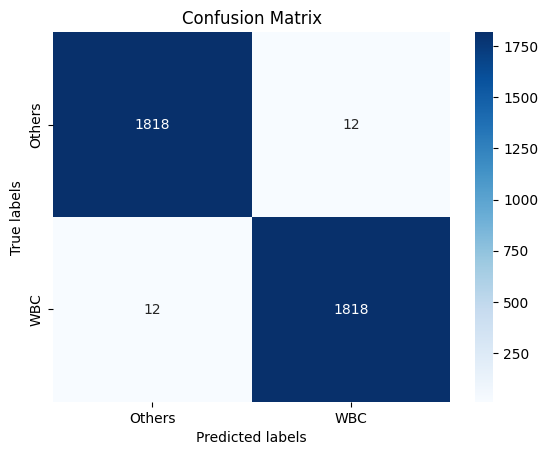

In [18]:
#print confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([0.5,1.5],['Others','WBC'])
plt.yticks([0.5,1.5],['Others','WBC'])
plt.title('Confusion Matrix')
plt.show()



Accuracy: 0.9934
AUROC: 0.9991
Precision-Recall AUC: 0.9985


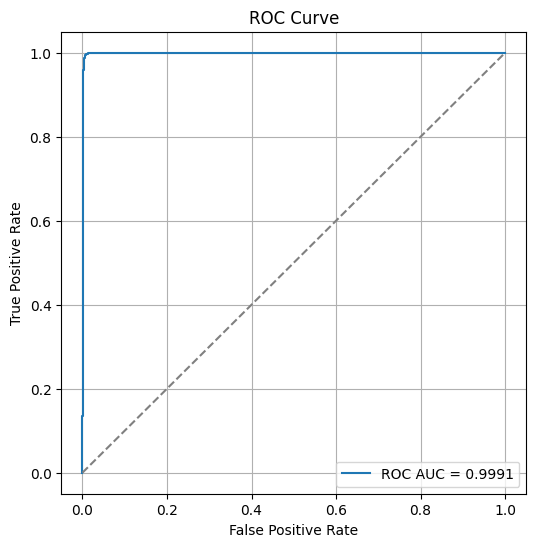

In [19]:

print(f"Accuracy: {accuracy:.4f}")

# Compute ROC AUC
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_true, y_probs)
pr_auc = average_precision_score(y_true, y_probs)

print(f"AUROC: {roc_auc:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")

# Plot ROC Curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

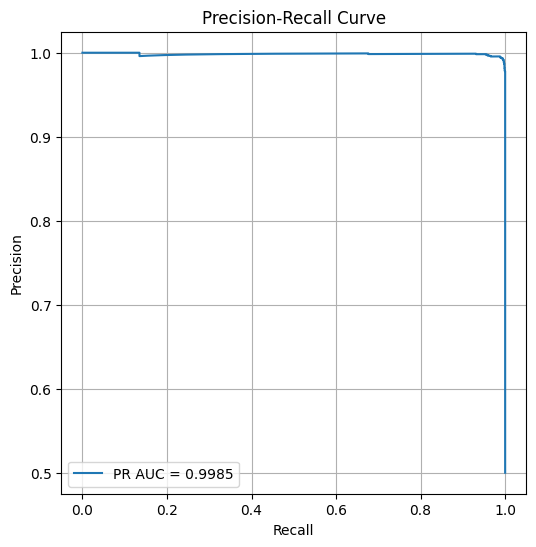

<Figure size 640x480 with 0 Axes>

In [20]:
# Plot Precision-Recall Curve
plt.figure(figsize=(6,6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()
